# Varying TR Height
Run a simple HYDRAD simulation and then plot the TR location as measured by where the heat flux switches from a sink to a source. Also prototyping a reader for the equation terms files.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import astropy.units as u
from hydrad_tools.configure import Configure
from hydrad_tools.parse import Strand
from hydrad_tools.visualize import plot_strand
from IPython.display import HTML

%matplotlib inline

In [2]:
base_config = Configure.load_config('/Users/willbarnes/Documents/work/codes/hydrad_tools/defaults.asdf')
base_config['general']['total_time'] = 5e3*u.s
base_config['general']['loop_length'] = 90*u.Mm
base_config['general']['loop_inclination'] = 0*u.deg
base_config['general']['heat_flux_limiting_coefficient'] = 1./6.
base_config['general']['write_file_equation_terms'] = True
base_config['initial_conditions']['heating_location'] = 45*u.Mm
base_config['initial_conditions']['heating_scale_height'] = 1e300*u.cm
base_config['heating']['events'] = [{'time_start': 0*u.s,
                                        'rise_duration': 100*u.s,
                                        'decay_duration': 100*u.s,
                                        'total_duration': 200*u.s,
                                        'location': 45*u.Mm,
                                        'scale_height': 1e300*u.cm,
                                        'rate': 0.1*u.erg/u.s/(u.cm**3)}]
base_config['grid']['enforce_conservation'] = False
base_config['grid']['linear_restriction'] = True
base_config['grid']['minimum_fractional_difference'] = 0.1
base_config['grid']['maximum_fractional_difference'] = 0.2

In [7]:
c = Configure(base_config)

In [8]:
c.config

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.0.1'},
 'general': {'footpoint_height': <Quantity 5.e+08 cm>,
  'force_single_fluid': False,
  'heat_flux_limiting_coefficient': 0.16666666666666666,
  'heat_flux_timestep_limit': <Quantity 1.e-10 s>,
  'logging_frequency': 1000,
  'loop_inclination': <Quantity 0. deg>,
  'loop_length': <Quantity 90. Mm>,
  'minimum_collisional_coupling_timescale': <Quantity 0.01 s>,
  'output_interval': <Quantity 1. s>,
  'total_time': <Quantity 5000. s>,
  'use_kinetic_model': False,
  'write_file_equation_terms': True,
  'write_file_hydrogen_level_populations': False,
  'write_file_ion_populations': False,
  'write_file_physical': True,
  'write_file_timescales': False},
 'grid': {'adapt': True,
  'adapt_every_n_time_steps': 10,
  'enforce_conservation': False,
  'linear_restriction': True,
  'maximum_cells': 30000,
  'maximum_fractional_difference

In [9]:
c.setup_simulation('.',name='test_hydrad_run_eq_terms',base_path='/Users/willbarnes/Documents/work/codes/HYDRAD/',)




../../Resources/Utils/regPoly/regpoly.cpp:34:24: warning: conversion from string literal to 'char *' is deprecated [-Wc++11-compat-deprecated-writable-strings]
if (mfit == 0) nrerror("lfit: no parameters to be fitted");
                       ^
../../Resources/Utils/regPoly/regpoly.cpp:125:36: warning: conversion from string literal to 'char *' is deprecated [-Wc++11-compat-deprecated-writable-strings]
        if (a[icol][icol] == 0.0) nrerror("gaussj: Singular Matrix");
                                          ^
../../Resources/Utils/regPoly/regpoly.cpp:98:23: warning: unused variable 'temp' [-Wunused-variable]
double big,dum,pivinv,temp;
                      ^
../../Resources/Utils/regPoly/regpoly.cpp:334:25: warning: conversion from string literal to 'char *' is deprecated [-Wc++11-compat-deprecated-writable-strings]
        if (its == 30) nrerror("no convergence in 30 svdcmp iterations");
                               ^
4 warnings generated.
../../Resources/Utils/regPoly/nrut

In [2]:
s = Strand('test_hydrad_run_eq_terms/')

In [3]:
s

HYDrodynamics and RADiation (HYDRAD) Code
-----------------------------------------
Results path: test_hydrad_run_eq_terms/
Time interval: [0.0 s, 5000.01 s]
Number of profiles: 5001
Loop length: 90.000 Mm

In [4]:
s[0]

HYDRAD Timestep Profile
--------------
Filename: test_hydrad_run_eq_terms/Results/profile0.phy
Timestep #: 0

In [28]:
with open('test_hydrad_run_eq_terms/Results/profile200.amr','r') as f:
    foo = f.readline()

In [29]:
foo

'200.001\n'

In [23]:
s.time[200].value

200.001

In [13]:
def get_dFds_half(t):
    i_time = np.where(s.time == t)[0][0]
    with open(os.path.join(s.hydrad_root,f'Results/profile{i_time}.trm')) as f:
        lines = f.readlines()
    energy_terms = []
    for l in lines[3::5]:
        energy_terms.append(np.array(l.split(),dtype=float))
    energy_terms = np.array(energy_terms)
    dFds = energy_terms[:,2]
    i_half = np.where(s[i_time].coordinate < s.loop_length/2.)
    s_half = s[i_time].coordinate[i_half]
    dFds_half = dFds[i_half]
    i_tr = np.where(dFds_half > 0) 
    s_interface = s_half[i_tr[0][-1]]
    return s_half,dFds_half,s_interface

In [15]:
s_interface = np.zeros(s.time.shape) * u.cm
for i,t in enumerate(s.time):
    #print(i)
    _,_,s_int = get_dFds_half(t)
    s_interface[i] = s_int

(0, 1)

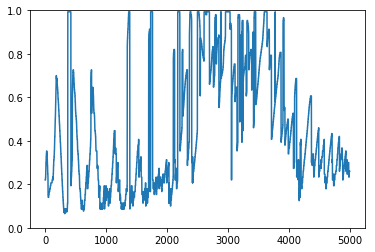

In [21]:
plt.plot(s.time,s_interface/(s.loop_length/2.))
plt.ylim(0,1)
#plt.yscale('log')
#plt.xlim(0,500)

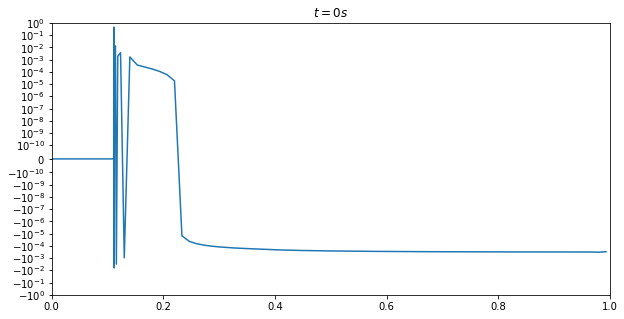

In [42]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.set_ylim(-1,1)
ax.set_xlim(0,1);
ax.set_yscale('symlog',linthreshy=1e-10)
s_half,dFds_half,s_int = get_dFds_half(s.time[0])
line1, = ax.plot(s_half/(s.loop_length/2.), dFds_half,'-')
def update_line(i):
    ax.set_title(f'$t={s.time[i]:5.0f}$')
    s_half,dFds_half,_ = get_dFds_half(s.time[i])
    line1.set_data(s_half/(s.loop_length/2.),dFds_half)
    return line1,
frames = [i for i,_ in enumerate(s.time)]
anim = matplotlib.animation.FuncAnimation(fig,update_line,frames=frames[:500],blit=True,interval=20,repeat=True)

In [43]:
HTML(anim.to_html5_video())

In [3]:
basic_config = {
        'general': {
            'minimum_collisional_coupling_timescale': 0.01*u.s,
            'force_single_fluid': False,
            'output_interval': 10*u.s,
            'total_time': 5e3*u.s,
            'write_file_physical': True,
            'write_file_ion_populations': True,
            'write_file_hydrogen_level_populations': True,
            'write_file_timescales': True,
            'write_file_equation_terms': True,
            'logging_frequency': 1000,
            'heat_flux_limiting_coefficient': 0.167,
            'heat_flux_timestep_limit': 1e-10*u.s,
            'use_kinetic_model': True,
            'loop_length': 90*u.Mm,
            'loop_inclination': 0*u.deg,
            'footpoint_height': 5*u.Mm,
            'tabulated_gravity_file': '/path/to/gravity.profile'
        },
        'initial_conditions': {
            'footpoint_temperature': 1e4*u.K,
            'footpoint_density': 1e12*u.cm**(-3),
            'heating_location': 45*u.Mm,
            'heating_scale_height': 1e300*u.cm,
            'isothermal': True,
            'heating_range_lower_bound': 1e-8*u.erg/(u.cm**3)/u.s,
            'heating_range_upper_bound': 1e2*u.erg/(u.cm**3)/u.s,
            'heating_range_step_size': 0.01,
            'heating_range_fine_tuning': 10000,
            'use_tabulated_gravity': True,
        },
        'grid': {
            'minimum_delta_s': 1.*u.cm,
            'maximum_variation': 0.1,
            'maximum_refinement_level': 12,
            'adapt': True,
            'adapt_every_n_time_steps': 1000,
            'refine_on_density': True,
            'refine_on_electron_energy': True,
            'refine_on_hydrogen_energy': True,
            'minimum_fractional_difference': 0.05,
            'maximum_fractional_difference': 0.1,
            'linear_restriction': True,
            'enforce_conservation': True,
            'minimum_cells': 150,
            'maximum_cells': 30000,
        },
        'solver': {
            'epsilon': 0.01,
            'safety_radiation': 0.1,
            'safety_conduction': 1.0,
            'safety_advection': 1.0,
            'safety_viscosity': 1.0,
            'timestep_increase_limit': 0.05,
            'minimum_radiation_temperature': 2e4*u.K,
            'zero_over_temperature_interval': 5e2*u.K,
            'minimum_temperature': 1e4*u.K,
            'maximum_optically_thin_density': 1e12*u.cm**(-3),
            'safety_atomic': 1.0,
            'cutoff_ion_fraction': 1e-6,
            'epsilon_d': 0.1,
            'epsilon_r': 1.8649415311920072,
        },
        'radiation': {
            'use_power_law_radiative_losses': False,
            'decouple_ionization_state_solver': True,
            'density_dependent_rates': False,
            'optically_thick_radiation': False,
            'nlte_chromosphere': False,
            'elements_nonequilibrium': ['iron'],
            'elements_equilibrium': ['iron', 'He', 1],
            'ranges_dataset': 'ranges',
            'emissivity_dataset': 'chianti_v7',
            'abundance_dataset': 'asplund',
            'rates_dataset': 'chianti_v7',
        },
        'heating': {
            'background_heating': False,
            'heat_electrons': True,
        }
    }

In [8]:
c = Configure(basic_config, freeze_date=False)

In [9]:
c.date

'2018-06-19_13.07.38'

In [10]:
c.date

'2018-06-19_13.07.39'

In [11]:
c.date

'2018-06-19_13.07.40'

In [60]:
print(c.collisions_header)

// ****
// *
// * #defines for configuring the shortest collisional coupling timescale
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-06-13_12.50.15
// *
// ****

// **** Physics ****
#define MINIMUM_COLLISIONAL_COUPLING_TIME_SCALE 0.01
#define FORCE_SINGLE_FLUID
// **** End of Physics ****


In [67]:
print(c.heating_cfg)

0.0 0.0 0.0

1

0.0 1e+300 0.1 0.0 100.0 100.0 200.0

Configuration file generated by hydrad_tools on 2018-06-13_13.01.09


In [74]:
print(c.heating_header)

// ****
// *
// * #defines for configuring the heating model
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-06-13_13.10.58
// *
// ****
#define HEATED_SPECIES 1
#define BEAM_HEATING
#define ALFVEN_WAVE_HEATING
#include "../../Radiation_Model/source/config.h"


In [81]:
print(c.hydrad_cfg)

Initial_Conditions/profiles/initial.amr
/path/to/gravity.profile
/path/to/cross.profile
5000.0
10.0

Configuration file generated by hydrad_tools on 2018-06-14_00.21.38


In [84]:
print(c.hydrad_header)

// ****
// *
// * #defines for configuring the hydrodynamic model
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-06-14_00.51.46
// *
// ****

// **** Output ****
#define WRITE_FILE_PHYSICAL
#define WRITE_FILE_ION_POPULATIONS
#define WRITE_FILE_HSTATE
#define WRITE_FILE_SCALES
#define WRITE_FILE_TERMS
#define OUTPUT_EVERY_N_TIME_STEPS 1000
// **** End of Output ****

// **** Physics ****
#include "../../Heating_Model/source/config.h"
#include "../../Radiation_Model/source/config.h"
#define HEAT_FLUX_LIMITING_COEFFICIENT 0.167
#define TIME_STEP_LIMIT 1e-10
#define USE_KINETIC_MODEL
#include "collisions.h"


// **** End of Physics ****

// **** Solver ****
#define SAFETY_RADIATION 0.1
#define SAFETY_CONDUCTION 1.0
#define SAFETY_ADVECTION 1.0
#define SAFETY_VISCOSITY 1.0
#define TIME_STEP_INCREASE_LIMIT 1.05

#define MINIMUM_RADIATION_TEMPERATURE 20000.0
#define ZERO_OVER_TEMPERATURE_INTERVAL 500.0
#define MINIMUM_TEMPERATURE 10000.0
// **** 

In [104]:
print(c.intial_conditions_cfg)

Initial_Conditions/profiles/initial.amr

9000000000.0
0.0
500000000.0

10000.0

1000000000000.0

4500000000.0
1e+300
-8.0
2.0
0.01
10000

Configuration file generated by hydrad_tools on 2018-06-16_19.02.44


In [117]:
print(c.initial_conditions_header)

// ****
// *
// * #defines for configuring the hydrostatic model
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-06-16_19.23.01
// *
// ****

// **** Output ****
// **** End of Output ****

// **** Physics ****
#include "../../Radiation_Model/source/config.h"
#define ISOTHERMAL
#define USE_TABULATED_GRAVITY
#define TABULATED_GRAVITY_FILE /path/to/gravity.profile

// **** Solver ****
#define EPSILON 0.01

// **** Grid ****
#define ADAPT
#define MIN_CELLS 150
#define MAX_CELLS 30000
#define MAX_REFINEMENT_LEVEL 12
#define MIN_DS 1.0
#define MAX_VARIATION 1.1


In [127]:
print(c.radiation_header)

// ****
// *
// * #defines for configuring the radiation model
// *
// * (c) Dr. Stephen J. Bradshaw
// *
// * Source code generated by hydrad_tools on 2018-06-18_23.45.50
// *
// ****

// **** Physics ****

#define NON_EQUILIBRIUM_RADIATION
#define DECOUPLE_IONIZATION_STATE_SOLVER




#include "../../HYDRAD/source/collisions.h"
// **** End of Physics ****

// **** Solver ****
#define MAX_OPTICALLY_THIN_DENSITY 1000000000000.0
#define SAFETY_ATOMIC 1.0
#define CUTOFF_ION_FRACTION 1e-06
#define EPSILON_D 0.1
#define EPSILON_R 1.8649415311920072
// **** End of Solver ****


In [131]:
print(c.radiation_nonequilibrium_cfg)

ranges
chianti_v7
asplund
chianti_v7
1
fe
26

Configuration file generated by hydrad_tools on 2018-06-19_00.06.39


In [130]:
print(c.radiation_equilibrium_cfg)

ranges
chianti_v7
asplund
chianti_v7
3
h
1
he
2
fe
26

Configuration file generated by hydrad_tools on 2018-06-19_00.04.11


In [86]:
foo = {'unit':'foo', 'units': 'bar'}

In [87]:
def get_keys(d, keys):
    for k in keys:
        v = d.get(k)
        if v is not None:
            return v
    else:
        return None

In [94]:
get_keys(foo,('foo','bar','units'))

'bar'